In [1]:
from AgentBasedModel import *
from AgentBasedModel.events.analysis import aggToShock
from AgentBasedModel.utils.math import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Simulation

Simulation: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1496.80it/s]


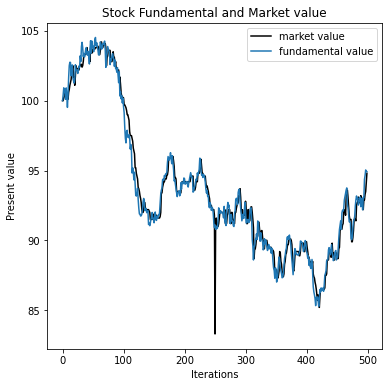

In [2]:
exchange = ExchangeAgent(volume=1000)
simulator = Simulator(**{
    'exchange': exchange,
    'traders': [Fundamentalist(exchange, 10**3) for _ in range(20)],
    'events': [MarketPriceShock(250, 500)]
})
info = simulator.info

simulator.simulate(500)
plot_price_fundamental(info)

### Aggregate statistics

In [3]:
data = aggToShock(simulator, 5, [
    ('return', lambda info, w: info.stock_returns(w)),
    ('return volatility', lambda info, w: info.return_volatility(w)),
    ('liquidity', lambda info, w: info.liquidity(w)),
    ('price volatility', lambda info, w: info.price_volatility(w))
])['Market Price shock (it=250, dp=500)']

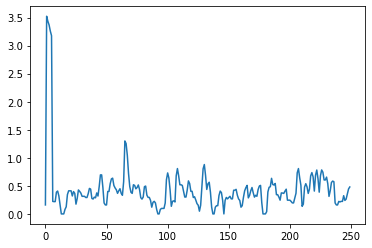

In [4]:
plt.plot(data['price volatility']['after'])

In [5]:
intervals = {stat: {k: vals for k, vals in v.items() if type(vals) == list} for stat, v in data.items()}
points = {stat: {k: vals for k, vals in v.items() if type(vals) == float} for stat, v in data.items()}

In [6]:
points

{'return': {'start': 0.0016991662171194147,
  'right before': -0.0010176902652383251,
  'right after': -0.018888140829983482,
  'end': 0.004566681007389999},
 'return volatility': {'start': 0.0011641454948159364,
  'right before': 0.001890991934652749,
  'right after': 0.036643261273084586,
  'end': 0.0029725051313577214},
 'liquidity': {'start': 0.003710820214491721,
  'right before': 0.0045489828223016825,
  'right after': 0.004999551037575755,
  'end': 0.014306661617463407},
 'price volatility': {'start': 0.22271057451319867,
  'right before': 0.11999999999999884,
  'right after': 0.16000000000000228,
  'end': 0.4799999999999989}}

### Visualisation

In [90]:
N_EXPERIMENTS = 100
WINDOW = 5

rf = info.exchange.risk_free
stats = [
    ('price', lambda info, w: list(map(lambda x: round(x, 1), rolling(info.prices, w)))),
    ('return', lambda info, w: info.stock_returns(w)),
    ('return volatility', lambda info, w: info.return_volatility(w)),
    ('price volatility', lambda info, w: info.price_volatility(w)),
    ('liquidity', lambda info, w: info.liquidity(w)),
    ('sharpe ratio', lambda info, w: [(r - rf) / v for r, v in zip(info.stock_returns(w), info.return_volatility(w))])
]

In [91]:
data = list()

for i in tqdm(range(N_EXPERIMENTS)):
    exchange = ExchangeAgent(volume=1000)
    simulator = Simulator(**{
        'exchange': exchange,
        'traders': [Fundamentalist(exchange, 10**3, access=10) for _ in range(20)],
        'events': [InformationShock(250, 1)]
    })
    info = simulator.info
    simulator.simulate(500, silent=True)
    
    tmp = aggToShock(simulator, WINDOW, stats)['Information shock (it=250, access=1)']
    
    intervals = {stat: {k: vals for k, vals in v.items() if type(vals) == list} for stat, v in tmp.items()}
    points = {stat: {k: vals for k, vals in v.items() if type(vals) == float} for stat, v in tmp.items()}
    
    data.append(points)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:58<00:00,  6.59s/it]


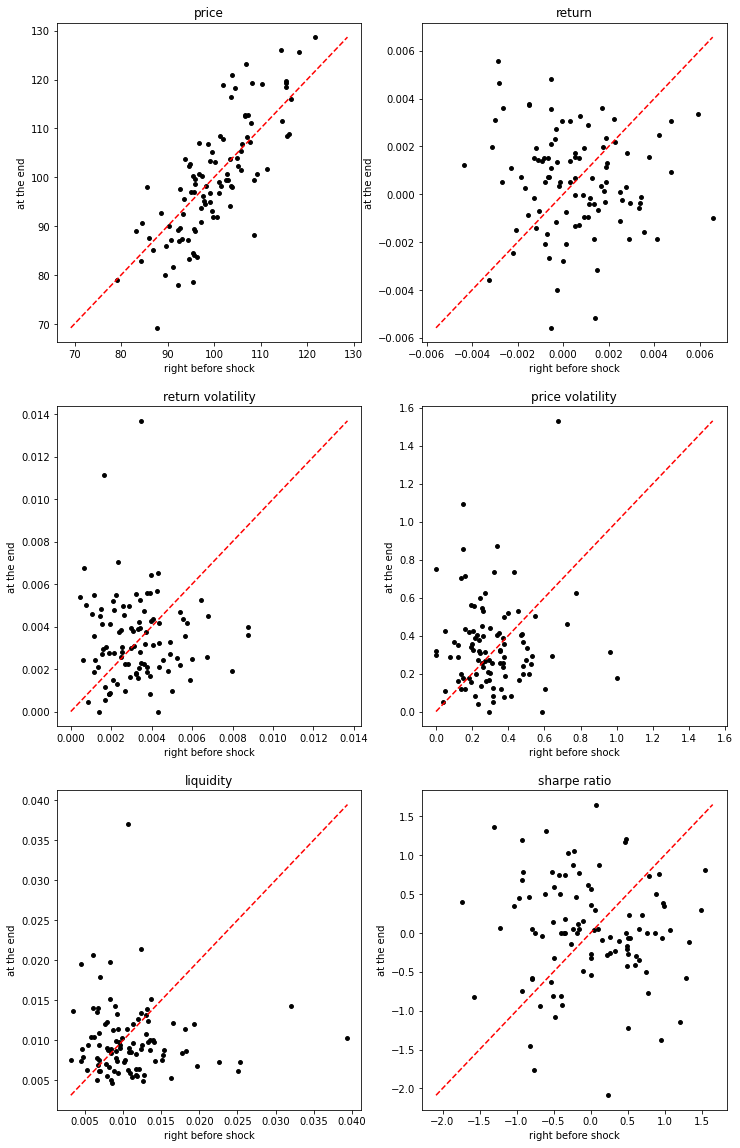

In [92]:
from math import ceil

fig, ax = plt.subplots(ceil(len(stats) / 2), 2, figsize=(12, 20))
for i, (name, func) in enumerate(stats):
    x = [v[name]['right before'] for v in data]
    y = [v[name]['end'] for v in data]

    ax[i // 2][i % 2].set_title(name)
    ax[i // 2][i % 2].scatter(x, y, s=15, c='black')
    ax[i // 2][i % 2].plot([min(min(x), min(y)), max(max(x), max(y))],
                           [min(min(x), min(y)), max(max(x), max(y))],
                           color='red', ls='--')
    ax[i // 2][i % 2].set_xlabel('right before shock')
    ax[i // 2][i % 2].set_ylabel('at the end')